In [3]:
import matplotlib.pyplot as plt
from downloadModelNet import ModelNet, downloadModelNet
import torch

# download the ModelNet10 dataset
# this may take around 10 minutes to process the data
downloadModelNet(nx=31)

Generating labels and preprocessing data
Processing train data
bathtub:  100.00%
bed:  100.00%
chair:  100.00%
desk:  100.00%
dresser:  100.00%
monitor:  100.00%
night_stand:  100.00%
sofa:  100.00%
table:  100.00%
toilet:  100.00%
Processing test data
bathtub:  100.00%
bed:  100.00%
chair:  100.00%
desk:  100.00%
dresser:  100.00%
monitor:  100.00%
night_stand:  100.00%
sofa:  100.00%
table:  100.00%
toilet:  100.00%


In [4]:
# initialize the dataset
train = ModelNet()
test = ModelNet(train=False)
print(len(train))
print(len(test))

3991
908


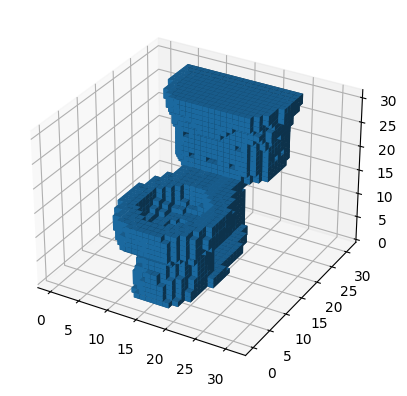

In [5]:
# plot a sample image from the test dataset
img = test[900][0] # toilet
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.voxels(img[0])
plt.show()

In [6]:
# define spatial coarsening and refinement functions
trilin_weight = torch.tensor([[[
    [
        [.125, .25, .125],
        [.25, .5, .25],
        [.125, .25, .125]
    ], [
        [.25, .5, .25],
        [.5, 1., .5],
        [.25, .5, .25]
    ], [
        [.125, .25, .125],
        [.25, .5, .25],
        [.125, .25, .125]
    ]
]]])

def coarsen(img):
    # Injection restriction (doesn't work too well with this data)
    # return img[:, :, 1::2, 1::2, 1::2]

    # Full weighting restriction
    nx = img.shape[2]
    nxc = (nx + 1) // 2 - 1
    batch = img.shape[0]
    channels = img.shape[1]

    return torch.nn.functional.conv3d(
        img.view(batch*channels, 1, nx, nx, nx), 
        trilin_weight, 
        stride=[2,2,2]).view(batch, channels, nxc, nxc, nxc)


def refine(img):
    # Trilinear interpolation
    nx = img.shape[2]
    nxf = (nx + 1) * 2 - 1
    batch = img.shape[0]
    channels = img.shape[1]

    return 1/6*torch.nn.functional.conv_transpose3d(
        img.view(batch*channels, 1, nx, nx, nx), 
        trilin_weight, 
        stride=[2,2,2]).view(batch, channels, nxf, nxf, nxf)


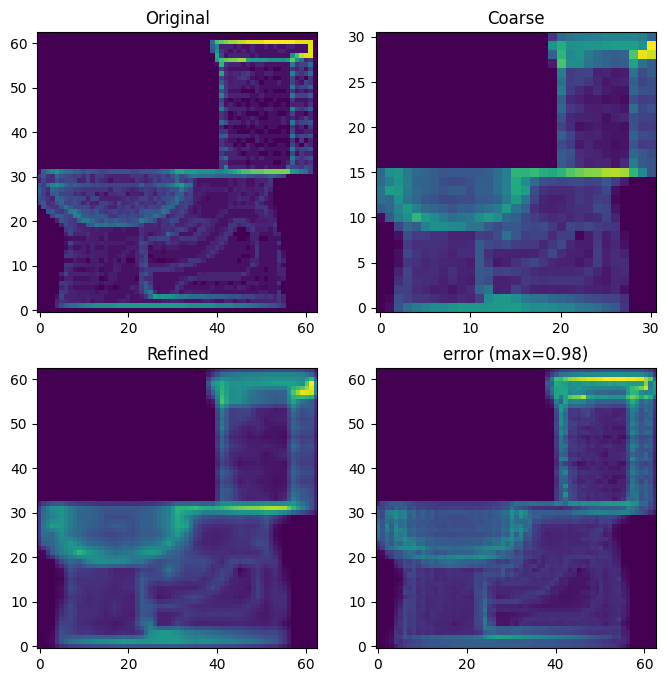

In [134]:
# coarsen and refine a sample image
from matplotlib import transforms

# img = train[rand_index][0]
img = test[900][0]
img = torch.unsqueeze(img, 0)
# img = new_refine(new_coarsen(img))
coarse = coarsen(img)
refined = refine(coarse)

tr = transforms.Affine2D().rotate_deg(-90)

dim = 0
# plot coarse, original, and refined
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(2, 2, 1)
ax.imshow(torch.sum(img[0][0], dim=dim).T, origin='lower')
ax.set_title("Original")

ax = fig.add_subplot(2, 2, 2)
ax.imshow(torch.sum(coarse[0][0], dim=dim).T, origin='lower')
ax.set_title("Coarse")

ax = fig.add_subplot(2, 2, 3)
ax.imshow(torch.sum(refined[0][0], dim=dim).T, origin='lower')
ax.set_title("Refined")

ax = fig.add_subplot(2, 2, 4)
error = torch.abs(img[0][0] - refined[0][0])
ax.imshow(torch.sum(error, dim=dim).T, origin='lower')
ax.set_title(f"error (max={torch.max(error):.2f})")
plt.show()

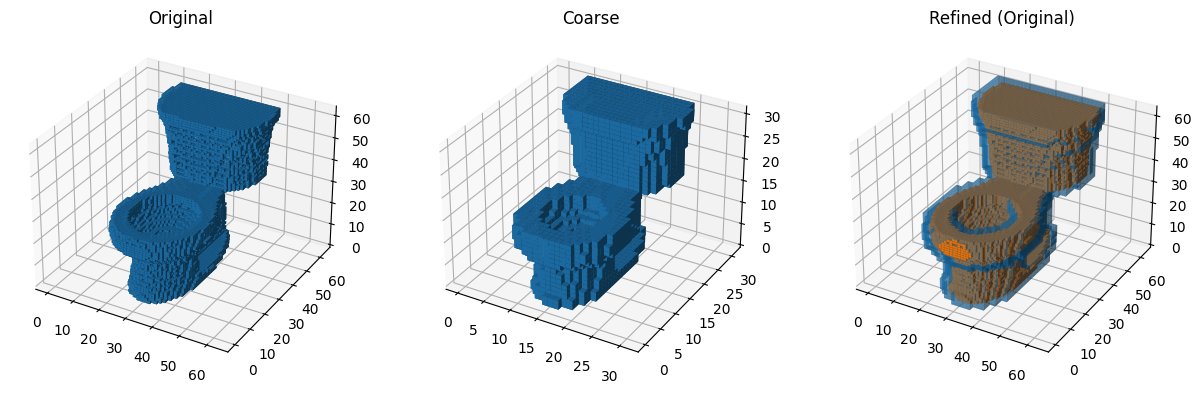

In [135]:
# coarsen and refine a sample image
img = test[900][0] # the toilet
# img = test[230][0] # a chair
img = torch.unsqueeze(img, 0)
coarse = new_coarsen(img)
refined = new_refine(coarse)

# plot coarse, original, and refined
fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(1, 3, 1, projection='3d')
ax.voxels(img[0][0])
ax.set_title("Original")
ax = fig.add_subplot(1, 3, 2, projection='3d')
ax.voxels(coarse[0][0])
ax.set_title("Coarse")
ax = fig.add_subplot(1, 3, 3, projection='3d')
ax.voxels(refined[0][0], alpha=0.5)
ax.voxels(img[0][0])
ax.set_title("Refined (Original)")
plt.show()

In [136]:
%timeit new_refine(new_coarsen(img))
%timeit refine(coarsen(img))

1.42 ms ± 8.38 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
392 µs ± 8.82 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
